In [1]:
import os
import math
from typing import TypedDict
from fastapi import FastAPI
from pydantic import BaseModel
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import  StateGraph, START, END
from transformers import AutoTokenizer, AutoModel
import torch

ImportError: cannot import name 'get_tracing_context' from 'langsmith.run_helpers' (c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langsmith\run_helpers.py)

In [4]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")


In [5]:
class InputState(TypedDict):
    suggested_answer:str
    student_answer:str

class OutputState(TypedDict):
    llm_score: float
    llm_feedback: str
    bart_score:float
    bert_score:float
    roberta_score:float
    t5_score:float
    embsdding_similarity_sroce: float
    hybrid_score:float

class OverallState(InputState,OutputState):
    pass


    
            

In [6]:
# Define a prompt template for LLM evaluation
scoring_prompt = PromptTemplate(
    input_variables=["suggested_answer", "student_answer"],
    template="""
Suggested answer: "{suggested_answer}"
Student’s answer: "{student_answer}"

Evaluate how well the student’s answer matches the suggested answer on a scale from 0 to 10,
considering correctness, completeness, and clarity. Provide a numeric score followed by a one-line feedback.
Example: "8.5 - Good answer but slightly lacks depth."
"""
)

# Initialize LLM and embeddings through LangChain
llm = OpenAI(model_name="gpt-4o", temperature=0)
chain = LLMChain(llm=llm, prompt=scoring_prompt)
embeddings = OpenAIEmbeddings()


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_community\llms\openai.py:255: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_community\llms\openai.py:1086: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_19476\731476925.py:16: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=scoring_prompt)


ModuleNotFoundError: No module named 'langchain.globals'

In [7]:

# Initialize Hugging Face tokenizer and models
def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    return tokenizer, model


In [8]:
bart_tokenizer, bart_model = load_model_and_tokenizer("facebook/bart-large")
bert_tokenizer, bert_model = load_model_and_tokenizer("bert-base-uncased")
roberta_tokenizer, roberta_model = load_model_and_tokenizer("roberta-base")
t5_tokenizer, t5_model = load_model_and_tokenizer("t5-small")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_cosine_similarity(embedding1, embedding2):
    """Utility to compute cosine similarity."""
    dot = torch.dot(embedding1, embedding2).item()
    norm1 = torch.norm(embedding1).item()
    norm2 = torch.norm(embedding2).item()
    return dot / (norm1 * norm2) if norm1 and norm2 else 0.0

In [12]:
def llm_evaluation_node(state: OverallState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Use LLMChain to evaluate student answer and return llm_score with feedback."""
    response = chain.run(suggested_answer=suggested_answer, student_answer=student_answer).strip()
    try:
        score, feedback = response.split(" - ", 1)
        score = float(score)
    except ValueError:
        score = 0.0
        feedback = "No valid feedback."
    return {"llm_score": score, "llm_feedback": feedback}

In [13]:
def bart_evaluation_node(state: OverallState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Evaluate using BART embeddings."""
    inputs = bart_tokenizer(suggested_answer, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bart_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    # Assuming you want to compare embeddings
    student_inputs = bart_tokenizer(student_answer, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        student_outputs = bart_model(**student_inputs)
        student_embeddings = student_outputs.last_hidden_state.mean(dim=1)
    score = compute_cosine_similarity(embeddings[0], student_embeddings[0])
    return {"bart_score": score * 10}

In [14]:
def bert_evaluation_node(state:OverallState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Evaluate using BERT embeddings."""
    inputs = bert_tokenizer([suggested_answer, student_answer], padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    score = compute_cosine_similarity(embeddings[0], embeddings[1])
    return {"bert_score": score * 10}

In [15]:


def compute_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.unsqueeze(0).detach().numpy(), embedding2.unsqueeze(0).detach().numpy())[0][0]

def roberta_evaluation_node(state:OverallState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Evaluate using RoBERTa embeddings."""
    inputs = roberta_tokenizer([suggested_answer, student_answer], padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = roberta_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    score = compute_cosine_similarity(embeddings[0], embeddings[1])
    return {"roberta_score": score * 10}

In [16]:

def t5_evaluation_node(state: InputState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Evaluate using T5 embeddings."""
    inputs = t5_tokenizer(suggested_answer, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = t5_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    student_inputs = t5_tokenizer(student_answer, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        student_outputs = t5_model(**student_inputs)
        student_embeddings = student_outputs.last_hidden_state.mean(dim=1)
    score = compute_cosine_similarity(embeddings[0], student_embeddings[0])
    return {"t5_score": score * 10}

In [17]:
def embedding_similarity_evaluation_node(state: OverallState) -> dict:
    suggested_answer = state['suggested_answer']
    student_answer = state['student_answer']
    """Evaluate using OpenAI embeddings."""
    vecs = embeddings.embed_documents([suggested_answer, student_answer])
    sim = compute_cosine_similarity(torch.tensor(vecs[0]), torch.tensor(vecs[1]))
    return {"embedding_similarity_score": sim * 10.0}

In [18]:
def hybrid_evaluation_node(llm_score: float, embedding_similarity_score: float) -> dict:
    """Combine LLM score and embedding similarity score."""
    return {"hybrid_score": (llm_score + embedding_similarity_score) / 2.0}

In [1]:
builder = StateGraph(OverallState, input=InputState, output=OutputState)

builder.add_node("llm_node", llm_evaluation_node)
#builder.add_node("embedding_node", embedding_similarity_evaluation_node)
builder.add_node("bart_node", bart_evaluation_node)
#builder.add_node("bert_node", bert_evaluation_node)
#builder.add_node("roberta_node", roberta_evaluation_node)
#builder.add_node("t5_node", t5_evaluation_node)
#builder.add_node("hybrid_node", hybrid_evaluation_node)

# Define edges
builder.add_edge(START, "llm_node")
#builder.add_edge(START, "embedding_node")
builder.add_edge("llm_node", "bart_node")
#builder.add_edge(START, "bert_node")
#builder.add_edge(START, "roberta_node")
#builder.add_edge(START, "t5_node")


builder.add_edge("llm_node", END)
#builder.add_edge("embedding_node", "hybrid_node")
builder.add_edge("bart_node",END)
#builder.add_edge("bert_node","hybrid_node")
#builder.add_edge("roberta_node","hybrid_node")
#builder.add_edge("t5_node","hybrid_node")

#builder.add_edge("hybrid_node", END)

graph = builder.compile()

NameError: name 'StateGraph' is not defined

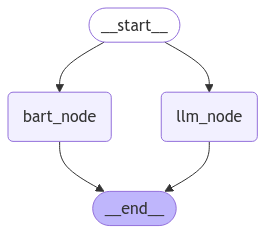

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
data=graph.invoke({
"suggested_answer": "Reaching the Target Audience: Affiliate marketing can extend the organization’s reach into new and existing market segments through affiliates who already have the trust and attention of these audiences. By partnering with affiliates that align with the organization’s target demographics and interests, the organization can efficiently broaden its reach.\n\nDriving Sales: Affiliates drive sales by leveraging their platforms (such as blogs, social media, email lists) to promote the organization’s products or services. Effective affiliates turn their audience’s trust into action, guiding them through the sales funnel. Strategies here include exclusive affiliate promotions, product reviews, and personalized affiliate links that track conversions.",
"student_answer":"Affiliate marketing is an effective strategy for organizations to reach their target audience and drive sales. By leveraging the trust and credibility of affiliates, businesses can expand their reach into both new and existing market segments. Affiliates, who already have established relationships with their audiences, serve as valuable partners in promoting products or services. Partnering with affiliates that align with the organization’s target demographics and interests ensures an efficient way to broaden the reach and establish a stronger presence in specific markets.Additionally, affiliate marketing is a powerful tool for driving sales. Affiliates utilize their platforms—such as blogs, social media, and email lists—to endorse and promote the organization’s offerings. This trusted endorsement often translates into audience action, moving potential customers through the sales funnel. Effective strategies employed by affiliates include offering exclusive promotions, writing product reviews, and using personalized affiliate links to track conversions. These methods not only enhance visibility but also ensure measurable outcomes for the organization.By partnering with affiliates who share similar values and appeal to the desired audience, businesses can effectively maximize their marketing efforts, build trust with potential customers, and achieve significant growth in sales and market reach. This mutually beneficial model drives results efficiently and sustainably."
})

APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [101]:
from fastapi import FastAPI, HTTPException,status
from fastapi.responses import JSONResponse

In [38]:
from fastapi import FastAPI
from pydantic import BaseModel
import logging

app = FastAPI()
logger = logging.getLogger(__name__)

class EvaluationRequest(BaseModel):
    suggested_answer: str
    student_answer: str

@app.post("/evaluate")
async def evaluate_answers(request: EvaluationRequest):
    logger.info("Received evaluation request: %s", request.dict())
    try:
        data = graph.invoke({
            "suggested_answer": request.suggested_answer,
            "student_answer": request.student_answer
        })
        logger.info("Evaluation successful: %s", data)
        return JSONResponse(
            content={"message": "Item evaluated successfully", "data": data},
            status_code=status.HTTP_200_OK
        )
    except Exception as e:
        logger.error("Error during evaluation: %s", str(e))
        return JSONResponse(
            content={"message": "An Error occurred during evaluation", "error": str(e)},
            status_code=status.HTTP_500_INTERNAL_SERVER_ERROR
        )

In [ ]:
if __name__ == "__main__":
    import threading
    import uvicorn
    threading.Thread(target=lambda: uvicorn.run(app, host="127.0.0.1", port=7500, log_level="info")).start()


INFO:     Started server process [19784]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:7500 (Press CTRL+C to quit)


INFO:     127.0.0.1:64028 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:64028 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:64028 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:64028 - "GET /openapi.json HTTP/1.1" 200 OK


C:\Users\USER\AppData\Local\Temp\ipykernel_19784\2838657306.py:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  logger.info("Received evaluation request: %s", request.dict())
C:\Users\USER\AppData\Local\Temp\ipykernel_19784\730431094.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chain.run(suggested_answer=suggested_answer, student_answer=student_answer).strip()
Error during evaluation: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old 

INFO:     127.0.0.1:64029 - "POST /evaluate HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_19784\2838657306.py", line 16, in evaluate_answers
    data = graph.invoke({
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langgraph\pregel\__init__.py", line 1936, in invoke
    for chunk in self.stream(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langgraph\pregel\__init__.py", line 1656, in stream
    for _ in runner.tick(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langgraph\pregel\runner.py", line 239, in tick
    _panic_or_proceed(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langgraph\pregel\runner.py", line 539, in _panic_or_proceed
    raise exc
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\langgraph\pregel\executor.py", line 76, in done
    task.result()
  File "c:\Users\USER\AppDa